In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.stats as ss

import pymc3 as pm

%matplotlib nbagg

np.random.seed(12345)

# Бейсов извод /Bayesian Inference/ с PyMC3

## Пример за Бейсов извод с процес на Бернули
Нека разгледаме процес на Бернули с параметър $\theta$

$P(x=1)=\theta$

$P(x=0)=1-\theta$

$ X = (x_i)_{i=1}^{100}$

In [2]:
theta = 0.6
size = 100

X = ss.bernoulli.rvs(theta, size=size)
X

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1])

### - Оценка с максимална правдоподобност /Maximum Likelihood Estimate/

In [3]:
np.sum(X)/np.size(X)

0.52000000000000002

### - Бейсов подход

In [4]:
class UpdateDist(object):
    def __init__(self, ax, data, prob, alpha=1, beta=1):
        self.data = data
        self.alpha=alpha
        self.beta=beta
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 10)
        self.ax.grid(True)

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(prob, linestyle='--', color='blue')

    def init(self):
        self.line.set_data(self.x, ss.beta.pdf(self.x, self.alpha, self.beta))
        return self.line,

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            return self.init()
        
        y = ss.beta.pdf(self.x, np.sum(X[:i]) + self.alpha, (i - np.sum(X[:i]) ) + self.beta)
        self.line.set_data(self.x, y)
        return self.line,


### Предполагаме, къде се намира най-вероятно $\theta$.

<IPython.core.display.Javascript object>


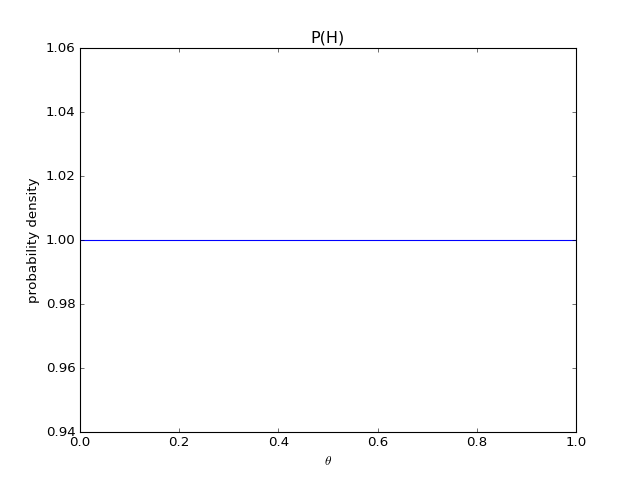

In [10]:
alpha = 1
beta = 1

x = np.linspace(0,1, 100)
plt.plot(x, ss.beta.pdf(x, alpha, beta))
plt.title('P(H)')
plt.ylabel('probability density')
plt.xlabel(r'$\theta$')

### Стартирайки с първоначалното предположение, обновяваме нашите виждания след всяко наблюдение.

<IPython.core.display.Javascript object>


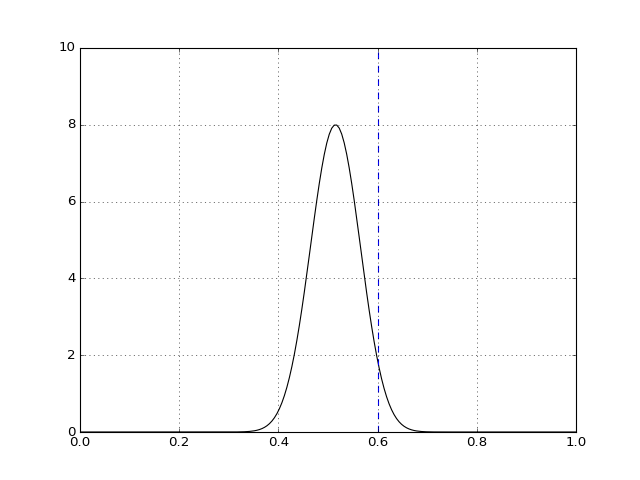

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ud = UpdateDist(ax, prob=theta, data=X, alpha=alpha, beta=beta)

anim = animation.FuncAnimation(fig, ud, frames=np.arange(size), init_func=ud.init, interval=500, blit=True, repeat=False)
plt.show()

## Как работи?

### Използваме формулата на Бейс:

### $$P(H|X)=\frac{P(X|H)P(H)}{P(X)}$$


Предположения:

- $H$ е моделът, който според нас обяснява данните - наричан хипотеза

- $P(H)$ е нашата вяра колко са вероятни различните стойности в $H$. При *достатъчно* данни, не влияе на резултата

Дадено:

- $X$ са наблюдаваните данни */дадени/*

- $P(H|X)$ e вероятността предполагаемият модел да обяснява данните $X$ */резултатат до момента/*

- $P(X|H)$ е вероятността да наблюдаваме данните $X$, ако $H$ e вярно */смята се от модела $H$/*

- $P(X)$ e вероятност да наблюдаваме $X$. Това се явява и нормализационна константа на числителя:

- не знаем колко точно е тази константа,но знаем,че

$$ P(X)=\int P(X|H) P(dH) $$




За горния пример, нека $s$ e броя успехи(1), а $f$ е броя неуспехи(0). Ако **вярваме**, че данните в X идват от процес на бернули, то той се описва с

$$P(X = (s, f) \mid H=\theta) = {s+f \choose s} \theta^s(1-\theta)^f$$

Нека изберем за начолно разпределение на $\theta \sim B(\alpha, \beta)$. За бета разпределението знаем, че 
- $B(1,1)$ e равномерно разпределение
- средното е $\alpha / (\alpha+\beta)$
- функцията на разпределение е
$$P(H=\theta) = {\theta^{\alpha-1}(1-\theta)^{\beta-1} \over B(\alpha,\beta)}$$

Така избрани, замесваме във формулата на Бейс

 $$ \begin{align}P(H=\theta \mid X = (s, f)) &= \frac{P(s, f \mid \theta)P(\theta)}{\int P(s, f \mid \theta)P(\theta)d\theta}\\
                   & = {{{s+f \choose s} \theta^{s+\alpha-1}(1-\theta)^{f+\beta-1} / B(\alpha,\beta)} \over \int_{y=0}^1 {s+f \choose s} y^{s+\alpha-1}(1-y)^{f+\beta-1}  dy/ B(\alpha,\beta)} \\
                   & = {\theta^{s+\alpha-1}(1-\theta)^{f+\beta-1} \over B(s+\alpha,f+\beta)}, \\
\end{align}$$

**Много малко разпределения могат да се интегрират аналитично.** За това Бейсовите методи не са разглеждани до 90-те години. Но с ползването на MCMC методи, нещата изведнъж стават възможни:

## Монте Карло с Марковски вериги /MCMC/ в Бейсови изводи

- Целта е да се приближи разпределение, чрез **Монте Карло**

- Разпределението се представя като стационарното състояние на **Марковска верига**


Applied logodds-transform to theta and added transformed theta_logodds to model.
 [-----------------100%-----------------] 4000 of 4000 complete in 6.7 sec

<IPython.core.display.Javascript object>


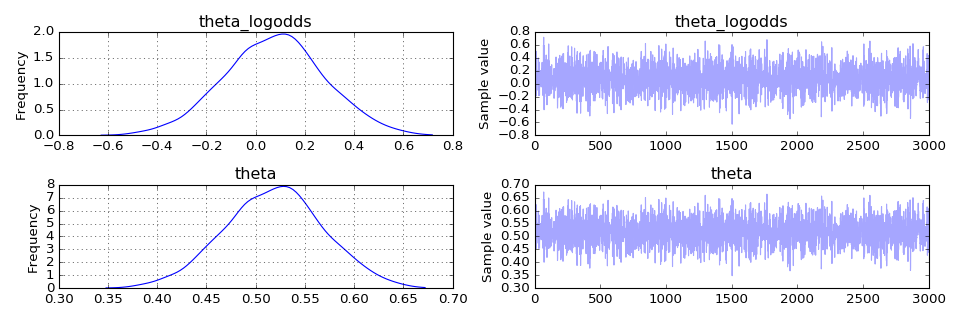

In [13]:
model = pm.Model()

with model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define random variables
    theta = pm.Beta('theta', alpha=alpha, beta=beta) # prior
    
    # Define how data relates to unknown causes
    data_a = pm.Bernoulli('data_a',
                          p=theta, 
                          observed=X)

    
    # Inference!
    start = pm.find_MAP() # Find good starting point
    step = pm.Slice() # Instantiate MCMC sampling algorithm
    trace = pm.sample(4000, step, start=start, progressbar=True) # draw posterior samples using slice sampling 
pm.traceplot(trace[1000:]);

*Пример 2:* имаме два търговеца. А има шанс 50% да е успешен, а B 60%.

In [14]:
np.random.seed(9)
algo_a = sp.stats.bernoulli(.5).rvs(300) # 50% profitable days
algo_b = sp.stats.bernoulli(.6).rvs(300) # 60% profitable days

In [15]:
model = pm.Model()

with model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define random variables
    theta_a = pm.Beta('theta_a', alpha=1, beta=1) # prior
    theta_b = pm.Beta('theta_b', alpha=1, beta=1) # prior
    
    # Define how data relates to unknown causes
    data_a = pm.Bernoulli('observed A',
                          p=theta_a, 
                          observed=algo_a)
    
    data_b = pm.Bernoulli('observed B', 
                          p=theta_b, 
                          observed=algo_b)
    
    # Inference!
    start = pm.find_MAP() # Find good starting point
    step = pm.Slice() # Instantiate MCMC sampling algorithm
    trace = pm.sample(10000, step, start=start, progressbar=False) # draw posterior samples using slice sampling 

Applied logodds-transform to theta_a and added transformed theta_a_logodds to model.
Applied logodds-transform to theta_b and added transformed theta_b_logodds to model.


<IPython.core.display.Javascript object>


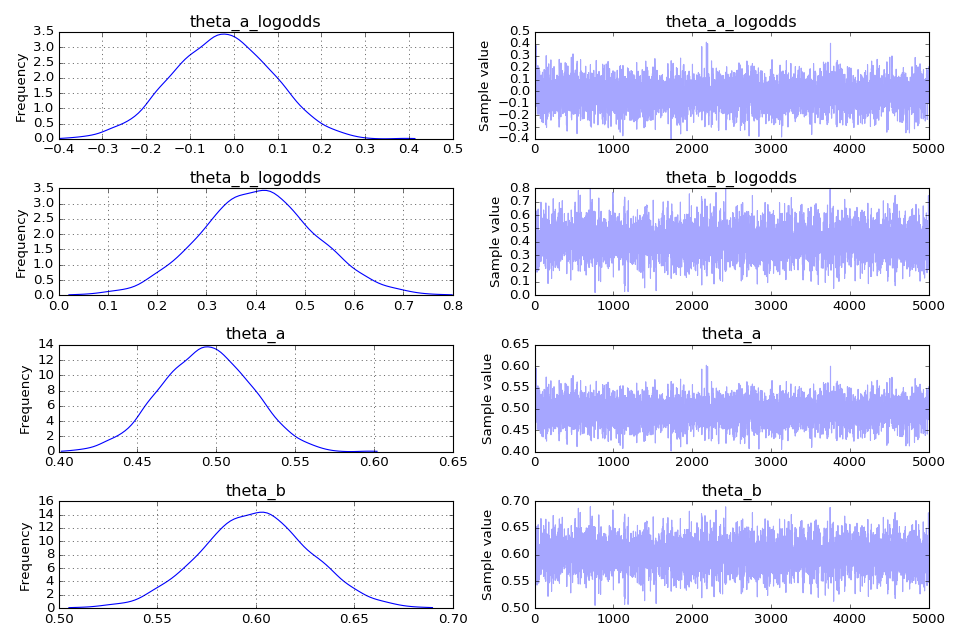

In [16]:
pm.traceplot(trace[5000:]);

Тестването на хипотеза е тривиално:

In [23]:
p_b_better_than_a = np.mean(trace['theta_a'] < trace['theta_b'])
print('P(algo B по-добър от A) = %.2f%%' % (p_b_better_than_a * 100))

P(algo B по-добър от A) = 99.63%


## Как работи?

- Искаме да следваме Марковска верига, чието стационарно разпределение $\pi$ да е желаната от нас вероятност
- Търсим $\pi T = \pi$
-  $\pi(x) T(x \to x') = \pi(x') T(x' \to x)$ уравнение на баланса
## Алгоритъм на Метрополис-Хастингс /Metropolis Hasting/

- избираме произволна начални параметри

- от текущата x стойност преминаваме в нова $x'$ според $Q(x \to x')$
- приемаме $x'$ с вероятност $A(x \to x')$
- това ни дава

$$ T(x \to x') = Q(x \to x')A(x \to x') $$

Заместваме в ур. на баланса

$$ \pi(x) Q(x \to x')A(x \to x') = \pi(x') Q(x' \to x)A(x' \to x) $$

$$\frac{A(x \to x')}{A(x' \to x)}=\frac{\pi(x') Q(x' \to x)}{ \pi(x) Q(x \to x')} $$

Например може да изберем

$$ A(x \to x') = \frac{\pi(x') Q(x' \to x)}{ \pi(x) Q(x \to x')} $$

$$A(x' \to x) = 1$$

$$ A(x \to x') = \max (1, \frac{\pi(x') Q(x' \to x)}{ \pi(x) Q(x \to x')}) $$

$Q$ участва с отношение: *не ни е нужна интеграционната константа*